In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py

import numpy as np
import pandas as pd

import yaml
import glob

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
def plot_wavefields(preds, trues, errors,initial_timestep,timestep_to_plot):
    fig , axs = plt.subplots(len(timestep_to_plot),3,figsize=(10,len(timestep_to_plot)*2.7),squeeze=False)

    for row, ts in enumerate(timestep_to_plot):

        # True
        im = axs[row,1].imshow(trues[row,:,:],norm=MidpointNormalize(midpoint=0))

        clim = im.get_clim()

        divider = make_axes_locatable(axs[row,1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        # Predictions
        im = axs[row,0].imshow(preds[row,:,:],norm=MidpointNormalize(midpoint=0),clim=clim)

        divider = make_axes_locatable(axs[row,0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
        axs[row,0].set_ylabel(f'Wavefield {ts}',fontsize=16)

        # Error
        im = axs[row,2].imshow(errors[row,:,:],norm=MidpointNormalize(midpoint=0))

        divider = make_axes_locatable(axs[row,2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        axs[row,0].tick_params(left=False,bottom=False)
        axs[row,0].set(yticklabels=[],xticklabels=[])
        axs[row,0].set_frame_on(False)
        axs[row,1].axis('off')
        axs[row,2].axis('off')

        if row == 0:
            axs[row,0].set_title(f'Prediction',fontsize=16)
            axs[row,1].set_title(f'True',fontsize=16)
            axs[row,2].set_title(f'Error',fontsize=16)
    
    plt.tight_layout()
    #fig.suptitle(f'Initital wavefield n°{initial_timestep} = 0.00 [s]', fontsize=30, y=1.02)

In [32]:
error = np.load('model_comparison/multiscale_errors_L2_GDL_MAE_E500.npy')
trues = np.load('model_comparison/multiscale_trues_L2_GDL_MAE_E500.npy')
preds = np.load('model_comparison/multiscale_preds_L2_GDL_MAE_E500.npy')

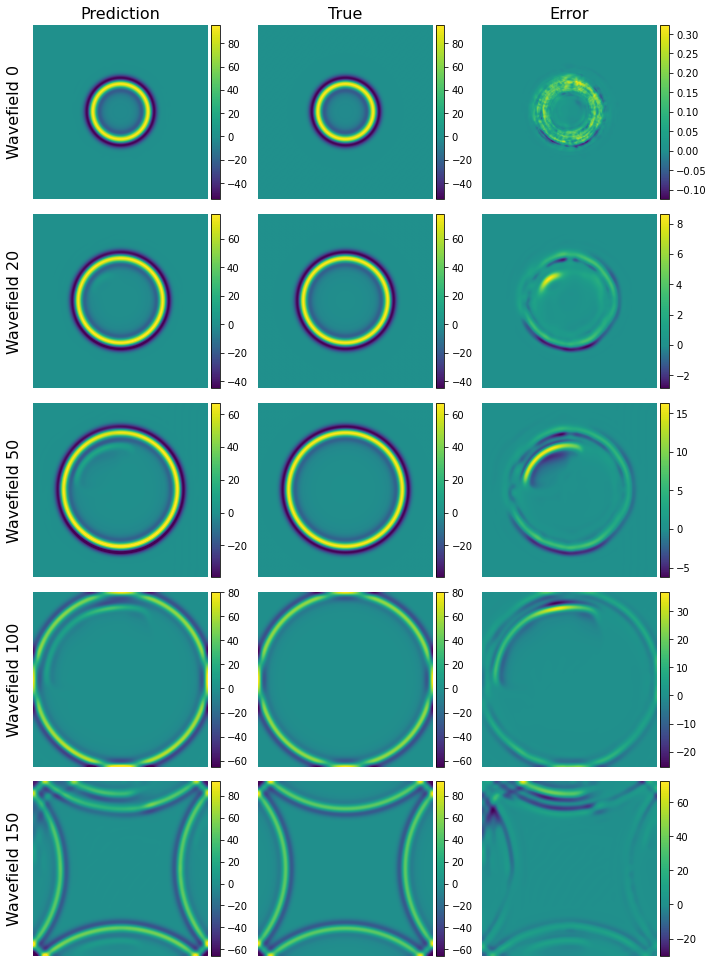

In [33]:
plot_wavefields(preds, trues, error, 0, [0,20,50,100,150])

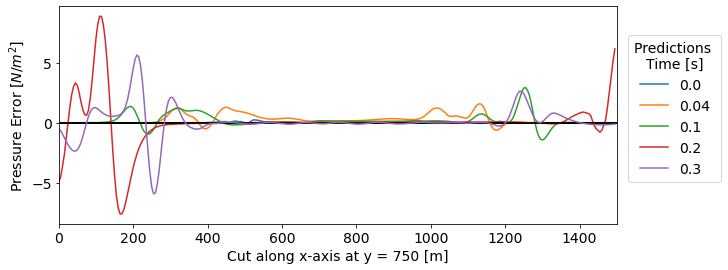

In [34]:
fig, ax = plt.subplots(figsize=(10,4))
for i, ts in enumerate([0,20,50,100,150]):
    ax.plot([0,1500],[0,0],'k')
    ax.plot(list(range(0,1500,5)),error[i,150,:],label=f'{ts*0.002}')
    ax.set_xlim(0,1500)
    ax.set_xlabel('Cut along x-axis at y = 750 [m]',fontsize = 14)
    ax.set_ylabel('Pressure Error $[N/m^2]$',fontsize = 14)
    ax.tick_params(axis='both', labelsize=14)

    leg = ax.legend(bbox_to_anchor=(1.2,0.9),loc='upper right',fontsize=14)
    leg.set_title("Predictions \nTime [s]",prop={'size':14})
    plt.setp(leg.get_title(), multialignment='center')

Training\encoder\results\L2_E500.yml
Training\encoder\results\L2_GDL_E500.yml
Training\encoder\results\L2_GDL_MAE_E500.yml
Training\multiscale\results\L2_E500.yml
Training\multiscale\results\L2_GDL_E500.yml
Training\multiscale\results\L2_GDL_MAE_E500.yml
Training\unet\results\L2_E500.yml
Training\unet\results\L2_GDL_E500.yml
Training\unet\results\L2_GDL_MAE_E500.yml


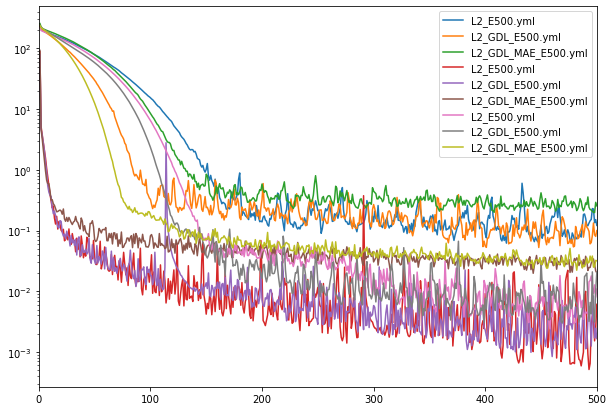

In [35]:
# Plot Loss function 
fig, ax = plt.subplots(figsize=(10,7))

for path in glob.glob('Training/*/results/*L2*.yml'):
    print(path)
    with open(path) as file:
        loss_list = yaml.load(file, Loader=yaml.FullLoader)

    df_loss = pd.DataFrame.from_dict(loss_list['train_evolution'])[1].apply(pd.Series)
    df_loss.index = pd.DataFrame.from_dict(loss_list['train_evolution'])[0]

    ax.plot(df_loss.index,df_loss.Loss,label=path.split('\\')[-1])
    ax.set_yscale('log')
    ax.set_xlim(0,500)

plt.legend()

In [36]:
model_name = 'model_comparison/multiscale_L2_GDL_MAE_E500.csv'

df_preds = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_pred'])['receivers_pred'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)
df_trues = pd.read_csv(model_name,index_col=0,usecols=['time','receivers_true'])['receivers_true'].str.replace(']','').str.replace('[','').str.replace('\n','').str.rstrip().str.lstrip().str.split('\s+',expand=True).astype(float)

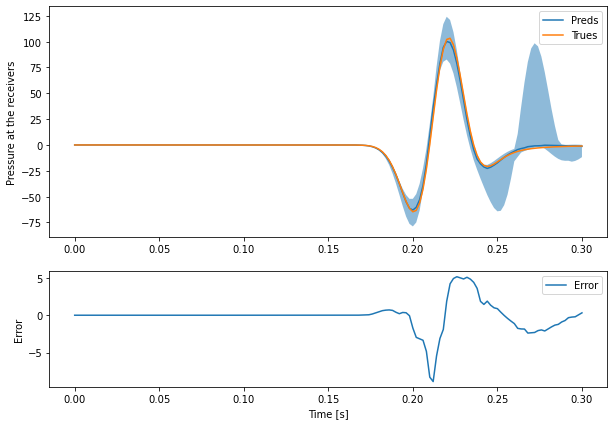

In [37]:
fig = plt.figure(figsize=(10,7))

spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[2, 1])

ax0 = fig.add_subplot(spec[0])
ax0.fill_between(df_preds.index,df_preds.max(axis=1),df_preds.min(axis=1),alpha=0.5)
ax0.plot(df_preds.index,df_preds.median(axis=1),label='Preds')

ax0.fill_between(df_trues.index,df_trues.max(axis=1),df_trues.min(axis=1),alpha=0.5)
ax0.plot(df_trues.index,df_trues.median(axis=1),label='Trues')
ax0.set_ylabel('Pressure at the receivers')
ax0.legend()

ax1 = fig.add_subplot(spec[1])
ax1.plot(df_preds.index,df_trues.median(axis=1)-df_preds.median(axis=1),label='Error')
ax1.set_ylabel('Error')
ax1.set_xlabel('Time [s]')

ax1.legend()